# sprint1 機械学習フロー

## 2.機械学習フロー

Kaggleの Home Credit Default Risk コンペティションを題材に、機械学習の実践的な流れを学びます。特に適切な 検証 を行い、高い 汎化性能 のあるモデルを完成させることを目指します。  
Home Credit Default Risk | Kaggle

## 【問題1】クロスバリデーション
事前学習期間では検証データをはじめに分割しておき、それに対して指標値を計算することで検証を行っていました。（ホールドアウト法）しかし、分割の仕方により精度は変化します。実践的には クロスバリデーション（交差検証） を行います。分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割のためにscikit-learnにはKFoldクラスが用意されています。

事前学習期間の課題で作成したベースラインモデルに対してKFoldクラスによるクロスバリデーションを行うコードを作成し実行してください。  
sklearn.model_selection.KFold — scikit-learn 0.21.3 documentation  
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold

### 1.1.1（準備)前処理

In [1]:
# 基本ライブラリのインポート
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 30)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import scipy.stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn import datasets
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import warnings # 実行に関係ない警告を無視
warnings.filterwarnings('ignore')

# データフレームを綺麗に出力する関数
import IPython
def display(*dfs, head=True):
    for df in dfs:
        IPython.display.display(df.head() if head else df)
        
pd.set_option('display.max_columns', 250)

In [2]:
# 訓練、検証データの読み込み
app_test= pd.read_csv("sample_dataset/home-credit-default-risk/application_test.csv")
app_train = pd.read_csv("sample_dataset/home-credit-default-risk/application_train.csv")

In [3]:
# ラベルエンコード（列数を増やさず、値を数字に変換する手法）
le = LabelEncoder()
le_count = 0
for col in app_train:
    # 値がオブジェクト型の時を条件指定。
    if app_train[col].dtype == "object":
        # カテゴリ数が２以下の条件指定。
        if len(list(app_train[col].unique())) <= 2:
            # 訓練データで学習を行う。
            le.fit(app_train[col])
            # 訓練、検証データ共に変換する。
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            le_count += 1

# one_hotエンコード (値は0と１のみ、列数をカテゴリ数分用意する手法)
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

In [4]:
# 元データを残す
train0 = app_train.copy()
test0 = app_test.copy()

# ターゲット値
train_labels = app_train['TARGET']

# id値
train_id = app_train["SK_ID_CURR"]
test_id = app_train["SK_ID_CURR"]

In [5]:
# A(app_train)とB(app_test)をjoin(両方含む)値に変換。
train1, test1 = train0.align(test0, join = 'inner', axis = 1)

print('Training Features shape: ', train1.shape)
print('Testing Features shape: ', test1.shape)

Training Features shape:  (307511, 239)
Testing Features shape:  (48744, 239)


In [6]:
# 特微量リスト
features = list(train1.columns)

In [7]:
# 欠損値を中央値で埋める
imputer = SimpleImputer(strategy = 'median')
imputer.fit(train1)
train2 = imputer.transform(train1)
test2 = imputer.transform(test1)

In [8]:
# 最小値0、最大値1に正規化
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(train2)
train3 = scaler.transform(train2)
test3 = scaler.transform(test2)

### 1.2.1(準備）ベースラインモデルの作成

In [9]:
# 訓練データ
train_df = pd.DataFrame(train3)
train_df.columns = features

#検証データ
test_df = pd.DataFrame(test3)
test_df.columns = features
train_df.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATIO

In [10]:
# 使用データの生成
train_df_t1 = train_df[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "DAYS_EMPLOYED"]]
test_df_t1 = test_df[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "DAYS_EMPLOYED"]]

# train_df_t1 = pd.concat(["train_id", "train_labels", "train_df_t1"],axis=1)
# test_df_t1 = pd.concat(["test_id", "test_df_t1"],axis=1)

train_df_t1 = train_df_t1[:100]
test_df_t1 = test_df_t1[:100]
train_labels_t1 = train_labels[:100]

print(train_df_t1.shape, test_df_t1.shape, train_labels_t1.shape)
train_df_t1.head()

(100, 4) (100, 4) (100,)


,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED
0,0.072215,0.307542,0.155054,0.045086
1,0.312933,0.727773,0.597163,0.043648
2,0.518318,0.650190,0.814130,0.046161
3,0.518318,0.760751,0.597163,0.038817
4,0.518318,0.377472,0.597163,0.038820


In [11]:
feature = train_df_t1
feature_names = list(feature.columns)
features = np.array(train_df_t1)
test_features = np.array(test_df_t1)
labels = train_labels_t1
features.shape

(100, 4)

In [12]:
# クロスバリデーション
k_fold = KFold(n_splits = 3, shuffle = False, random_state = 0)

# Empty array for feature importances
feature_importance_values = np.zeros(len(feature_names))

# Empty array for test predictions
test_predictions = np.zeros(test_features.shape[0])

# Empty array for out of fold validation predictions
out_of_fold = np.zeros(features.shape[0])

# Lists for recording validation and training scores
valid_scores = []
train_scores = []

# Iterate through each fold
for train_indices, valid_indices in k_fold.split(features):
    print(train_indices[:5], valid_indices[:5])

    # Training data for the fold
    train_features, train_labels = features[train_indices], labels[train_indices]
    # Validation data for the fold
    valid_features, valid_labels = features[valid_indices], labels[valid_indices] 
    
    # from sklearn.ensemble import RandomForestClassifier
    rfc = RandomForestClassifier(max_depth=2)
    rfc.fit(train_features, train_labels)
    rfc_pred = rfc.predict_proba(valid_features)[:, 1]
    # rfc_vai = rfc.predict(valid_feature)
    
    score = roc_auc_score(valid_labels, rfc_pred)
    
    valid_scores.append(score)

    # AUC評価
    print("AUC:",score)

[34 35 36 37 38] [0 1 2 3 4]
AUC: 0.9375
[0 1 2 3 4] [34 35 36 37 38]
AUC: 0.31451612903225806
[0 1 2 3 4] [67 68 69 70 71]
AUC: 0.6935483870967742


In [13]:
print(valid_scores)
print(sum(valid_scores)/3)

[0.9375, 0.31451612903225806, 0.6935483870967742]
0.6485215053763441


## 【問題2】グリッドサーチ
これまで分類器のパラメータには触れず、デフォルトの設定を使用していました。パラメータの詳細は今後のSprintで学んでいくことになります。機械学習の前提として、パラメータは状況に応じて最適なものを選ぶ必要があります。最適なパラメータを探していくことを パラメータチューニング と呼びます。パラメータチューニングをある程度自動化する単純な方法としては グリッドサーチ があります。

scikit-learnのGridSearchCVを使い、グリッドサーチを行うコードを作成してください。そして、ベースラインモデルに対して何らかしらのパラメータチューニングを行なってください。どのパラメータをチューニングするかは、使用した手法の公式ドキュメントを参考にしてください。  
sklearn.model_selection.GridSearchCV — scikit-learn 0.21.3 documentation  
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

GridSearchCVクラスには引数としてモデル、探索範囲、さらにクロスバリデーションを何分割で行うかを与えます。クロスバリデーションの機能も含まれているため、これを使用する場合はKFoldクラスを利用する必要はありません。

In [14]:
# 分割
X_train, X_test, Y_train, Y_test = train_test_split(train_df_t1, train_labels_t1, test_size=0.20, random_state=0)

In [15]:
# ランダムフォレストのパラメーター
RFC_grid = {RandomForestClassifier(): {"n_estimators": [i for i in range(1, 11)],
                                       "criterion": ["gini", "entropy"],
                                       "max_depth":[i for i in range(1, 5)]
                                      }}
max_score = 0
SearchMethod = 0

#ランダムフォレストの実行
for model, param in tqdm(RFC_grid.items()):
    clf = GridSearchCV(model, param)
    clf.fit(X_train,  Y_train)
    Y_pred = clf.predict(X_test)
    score = f1_score(Y_test, Y_pred, average="micro")

    if max_score < score:
        max_score = score
        best_param = clf.best_params_
        best_model = model.__class__.__name__

print("ベストスコア:{}".format(max_score))
print("モデル:{}".format(best_model))
print("パラメーター:{}".format(best_param))

100%|██████████| 1/1 [00:09<00:00,  9.77s/it]

ベストスコア:0.9500000000000001
モデル:RandomForestClassifier
パラメーター:{'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 3}


In [16]:
# クロスバリデーション
k_fold = KFold(n_splits = 3, shuffle = False, random_state = 0)

# Empty array for feature importances
feature_importance_values = np.zeros(len(feature_names))

# Empty array for test predictions
test_predictions = np.zeros(test_features.shape[0])

# Empty array for out of fold validation predictions
out_of_fold = np.zeros(features.shape[0])

# Lists for recording validation and training scores
valid_scores_g = []
train_scores_g = []

# Iterate through each fold
for train_indices, valid_indices in k_fold.split(features):
    print(train_indices[:5], valid_indices[:5])

    # Training data for the fold
    train_features, train_labels = features[train_indices], labels[train_indices]
    # Validation data for the fold
    valid_features, valid_labels = features[valid_indices], labels[valid_indices] 
    
    # from sklearn.ensemble import RandomForestClassifier
    rfc = RandomForestClassifier(max_depth=1, n_estimators=3, criterion="gini")
    rfc.fit(train_features, train_labels)
    rfc_pred = rfc.predict_proba(valid_features)[:, 1]
    # rfc_vai = rfc.predict(valid_feature)
    
    score = roc_auc_score(valid_labels, rfc_pred)
    
    valid_scores_g.append(score)

    # AUC評価
    print("AUC:",score)

[34 35 36 37 38] [0 1 2 3 4]
AUC: 0.9453125
[0 1 2 3 4] [34 35 36 37 38]
AUC: 0.41935483870967744
[0 1 2 3 4] [67 68 69 70 71]
AUC: 0.5564516129032258


In [17]:
print(valid_scores_g)
print(sum(valid_scores_g)/3)

[0.9453125, 0.41935483870967744, 0.5564516129032258]
0.6403729838709677


## 【問題3】Kaggle Notebooksからの調査  
KaggleのNotebooksから様々なアイデアを見つけ出して、列挙してください。

### 3.1.1（解答）
- LigthGBM  https://www.codexa.net/lightgbm-beginner/
- Feature Importance   https://mathmatical22.xyz/2020/04/12/%E3%80%90%E5%88%9D%E5%BF%83%E8%80%85%E5%90%91%E3%81%91%E3%80%91%E7%89%B9%E5%BE%B4%E9%87%8F%E9%87%8D%E8%A6%81%E5%BA%A6%E3%81%AE%E7%AE%97%E5%87%BA-lightgbm-%E3%80%90python%E3%80%91%E3%80%90%E6%A9%9F/
- Permutation Importance  https://qiita.com/kenmatsu4/items/c49059f78c2b6fed0929
- GXBoost、ランダムサーチ、ベイズ最適化   https://www.codexa.net/hyperparameter-tuning-python/

### 3.2.1（予備知識）
- Scaler    https://helve-python.hatenablog.jp/entry/scikitlearn-scale-conversion
- stratify  https://www.haya-programming.com/entry/2019/06/23/205121

## 【問題4】高い汎化性能のモデル作成
問題3で見つけたアイデアと、独自のアイデアを組み合わせ高い汎化性能のモデル作りを進めてください。  
その過程として、何を行うことで、クロスバリデーションの結果がどの程度変化したかを表にまとめてください。

### 4.1.1（解答） LigthGBM & Feature Importance

In [18]:
# 特徴量重要度を棒グラフでプロットする関数 
def plot_feature_importance(df):
    n_feature = len(df)                              # 特徴量数(説明変数の個数) 
    df_plot = df.sort_values('importance')            # df_importanceをプロット用に特徴量重要度を昇順ソート 
    f_importance_plot = df_plot['importance'].values  # 特徴量重要度の取得 
    plt.barh(range(n_feature), f_importance_plot, align='center') 
    cols_plot = df_plot['feature'].values             # 特徴量の取得 
    plt.yticks(np.arange(n_feature), cols_plot)      # x軸,y軸の値の設定
    plt.xlabel('Feature importance')                  # x軸のタイトル
    plt.ylabel('Feature')                             # y軸のタイトル

In [19]:
# Breast Cancer データセットの読み込み 
app_train = pd.read_csv("sample_dataset/home-credit-default-risk/application_train.csv")
app_test = pd.read_csv("sample_dataset/home-credit-default-risk/application_test.csv")

In [20]:
# ラベルエンコード（列数を増やさず、値を数字に変換する手法）
le = LabelEncoder()
le_count = 0
for col in app_train:
    # 値がオブジェクト型の時を条件指定。
    if app_train[col].dtype == "object":
        # カテゴリ数が２以下の条件指定。
        if len(list(app_train[col].unique())) <= 2:
            # 訓練データで学習を行う。
            le.fit(app_train[col])
            # 訓練、検証データ共に変換する。
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            le_count += 1

# one_hotエンコード (値は0と１のみ、列数をカテゴリ数分用意する手法)
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

In [21]:
df_train = pd.DataFrame(app_train) # データフレームへの格納
df_test = pd.DataFrame(app_test)   # データフレームへの格納
target = df_train["TARGET"]

# データの確認 
print(df_train.shape) # データサイズの確認(データ数,特徴量数) 
display(df_train) # df.head()に同じ(文中に入れるときはdisplay()を使う) 

# 説明変数,目的変数 
X = df_train.drop('TARGET',axis=1).values # 説明変数(target以外の特徴量) 
y = target.values                         # 目的変数(target) 

# トレーニングデータ,テストデータの分割 
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=2)

(307511, 243)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business 

In [22]:
# 学習に使用するデータを設定
import lightgbm as lgb #LightGBM
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train) 

# LightGBM parameters
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression', # 目的 : 回帰  
        'metric': {'rmse'}, # 評価指標 : rsme(平均二乗誤差の平方根) 
}

# モデルの学習
model = lgb.train(params,
                  train_set=lgb_train, # トレーニングデータの指定
                  valid_sets=lgb_eval, # 検証データの指定
                  )

[1]	valid_0's rmse: 0.270668
[2]	valid_0's rmse: 0.269482
[3]	valid_0's rmse: 0.268495
[4]	valid_0's rmse: 0.267691
[5]	valid_0's rmse: 0.267025
[6]	valid_0's rmse: 0.266442
[7]	valid_0's rmse: 0.265949
[8]	valid_0's rmse: 0.265533
[9]	valid_0's rmse: 0.265174
[10]	valid_0's rmse: 0.264843
[11]	valid_0's rmse: 0.264571
[12]	valid_0's rmse: 0.264309
[13]	valid_0's rmse: 0.264095
[14]	valid_0's rmse: 0.263884
[15]	valid_0's rmse: 0.263695
[16]	valid_0's rmse: 0.263516
[17]	valid_0's rmse: 0.263357
[18]	valid_0's rmse: 0.263183
[19]	valid_0's rmse: 0.263051
[20]	valid_0's rmse: 0.262921
[21]	valid_0's rmse: 0.262795
[22]	valid_0's rmse: 0.262675
[23]	valid_0's rmse: 0.262589
[24]	valid_0's rmse: 0.262495
[25]	valid_0's rmse: 0.262429
[26]	valid_0's rmse: 0.262311
[27]	valid_0's rmse: 0.262249
[28]	valid_0's rmse: 0.262116
[29]	valid_0's rmse: 0.262046
[30]	valid_0's rmse: 0.261996
[31]	valid_0's rmse: 0.261938
[32]	valid_0's rmse: 0.26187
[33]	valid_0's rmse: 0.261808
[34]	valid_0's rmse:

In [23]:
# 特徴量重要度の算出 (データフレームで取得)
cols = list(app_train.drop('TARGET',axis=1).columns)       # 特徴量名のリスト(目的変数CRIM以外)
# 特徴量重要度の算出方法 'gain'(推奨) : トレーニングデータの損失の減少量を評価
f_importance = np.array(model.feature_importance(importance_type='gain')) # 特徴量重要度の算出 //
f_importance = f_importance / np.sum(f_importance) # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
df_importance.head(15)

,feature,importance
33,EXT_SOURCE_3,0.254876
32,EXT_SOURCE_2,0.239995
31,EXT_SOURCE_1,0.084017
10,DAYS_BIRTH,0.046128
6,AMT_CREDIT,0.034508
7,AMT_ANNUITY,0.030694
8,AMT_GOODS_PRICE,0.030043
11,DAYS_EMPLOYED,0.021546
13,DAYS_ID_PUBLISH,0.015728
12,DAYS_REGISTRATION,0.015094


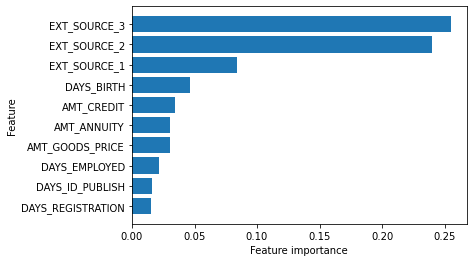

In [24]:
# 特徴量重要度の可視化
n_display = 10 # 上位10個に制限
plot_feature_importance(df_importance.iloc[:n_display,:])

### 4.2.1（解答） GXBoost、ベースラインモデル

In [25]:
# A(app_train)とB(app_test)をjoin(両方含む)値に変換。
X, Y = df_train.align(df_test, join = 'inner', axis = 1)

print('Training Features shape: ', X.shape)
print('Testing Features shape: ', Y.shape)

Training Features shape:  (307511, 239)
Testing Features shape:  (48744, 239)


In [26]:
# 欠損値を平均値で埋める
imputer = SimpleImputer(strategy = 'mean')
imputer.fit(X)
train_gx = imputer.transform(X)
test_gx = imputer.transform(Y)

In [27]:
X.isnull().sum()

SK_ID_CURR                         0
NAME_CONTRACT_TYPE                 0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
                                  ..
WALLSMATERIAL_MODE_Panel           0
WALLSMATERIAL_MODE_Stone, brick    0
WALLSMATERIAL_MODE_Wooden          0
EMERGENCYSTATE_MODE_No             0
EMERGENCYSTATE_MODE_Yes            0
Length: 239, dtype: int64

In [28]:
X_tr_gx, X_te_gx, Y_tr_gx, Y_te_gx = train_test_split(X, target , test_size=0.20, random_state=5)
X_tr_gx = X_tr_gx[:100]
X_te_gx = X_te_gx[:100]
Y_tr_gx = Y_tr_gx[:100]
Y_te_gx = Y_te_gx[:100]
X_tr_gx.shape, X_te_gx.shape, Y_tr_gx.shape, Y_te_gx.shape

((100, 239), (100, 239), (100,), (100,))

In [29]:
type(X_tr_gx)

pandas.core.frame.DataFrame

In [30]:
import xgboost as xgb

params = {'metric':'error',
          'objective':'binary:logistic',
          'n_estimators':50000,
          'booster': 'gbtree',
          'learning_rate':0.01,
          'min_child_weight':1,
          'max_depth':5,
          'random_state':0,
          'colsample_bytree':1,
          'subsample':1,
         }

cls = xgb.XGBClassifier()
cls.set_params(**params)
cls.fit(X_tr_gx,
       Y_tr_gx,
        early_stopping_rounds=50,
        eval_set=[(X_te_gx,Y_te_gx)],
        eval_metric="error",
        verbose=1)

[14:21:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.23000
Will train until validation_0-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.23000
[2]	validation_0-error:0.23000
[3]	validation_0-error:0.23000
[4]	validation_0-error:0.23000
[5]	validation_0-error:0.23000
[6]	validation_0-error:0.23000
[7]	validation_0-error:0.23000
[8]	validation_0-error:0.23000
[9]	validation_0-error:0.23000
[10]	validation_0-error:0.23000
[11]	validation_0-error:0.23000
[12]	validation_0-error:0.23000
[13]	validation_0-error:0.23000
[14]	validation_0-error:0.23000
[15]	validation_0-error:0.23000
[16]	validation_0-error:0.23000
[17]	validation_0-error:0.23000
[18]	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5, metric='error',
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
print("best score:", cls.best_score)
print("best iter:",cls.best_iteration)

best score: 0.2
best iter: 48


In [32]:
pred_1 = cls.predict(X_te_gx)
baseline = accuracy_score(Y_te_gx, pred_1)
print("スコア:",baseline)

スコア: 0.8


In [33]:
pred_1_mat = confusion_matrix(Y_te_gx, pred_1)
print("混合行列:\n",pred_1_mat)

混合行列:
 [[80  8]
 [12  0]]


### 4.2.2（解答）XGBoost、グリッドサーチ

In [34]:
cv_params = {'metric':['error'],
             'objective':['binary:logistic'],
             'n_estimators':[50000],
             'random_state':[0],
             'booster': ['gbtree'],
             'learning_rate':[0.01],
             'min_child_weight':[1,5],
             'max_depth':[1,3],
             'colsample_bytree':[0.5,1.0],
             'subsample':[0.5,1.0]
            }
 
cls = xgb.XGBClassifier()
cls_grid = GridSearchCV(cls, cv_params, cv=KFold(2, random_state=0), scoring='accuracy', iid=False)
cls_grid.fit(X_tr_gx,
             Y_tr_gx,
             early_stopping_rounds=50,
             eval_set=[(X_te_gx, Y_te_gx)],
             eval_metric='error',
             verbose=0)

[14:21:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:21:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:21:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

GridSearchCV(cv=KFold(n_splits=2, random_state=0, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, mono...
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             iid=False,
             param_grid={'booster': ['gbtree'], 'colsample_bytree': [0.5, 1.0],
     

In [35]:
print(cls_grid.best_params_)
print(cls_grid.best_score_)

{'booster': 'gbtree', 'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 1, 'metric': 'error', 'min_child_weight': 1, 'n_estimators': 50000, 'objective': 'binary:logistic', 'random_state': 0, 'subsample': 0.5}
0.9


In [36]:
pred_2 = cls_grid.best_estimator_.predict(X_te_gx)
grid_score = accuracy_score(Y_te_gx, pred_2)
print("スコア：",grid_score)

スコア： 0.88


In [37]:
pred_2_mat = confusion_matrix(Y_te_gx, pred_2)
print("混合行列:\n",pred_2_mat)

混合行列:
 [[88  0]
 [12  0]]


### 4.2.3（解答）XGBoost、ランダムサーチ

In [38]:
cv_params = {'metric':['error'],
             'objective':['binary:logistic'],
             'n_estimators':[50000],
             'random_state':[0],
             'boosting_type': ['gbdt'],
             'learning_rate':[0.01],
             'min_child_weight':[1,2,3,4,5,6,7,8,9,10],
             'max_depth':[1,2,3,4,5,6,7,8,9,10],
             'colsample_bytree':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
             'subsample':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
            }
 
cls = xgb.XGBClassifier()
cls_rdn = RandomizedSearchCV(cls,
                             cv_params,
                             cv=KFold(2, random_state=0),
                             random_state=0,
                             n_iter=30,
                             iid=False,
                             scoring='accuracy')
cls_rdn.fit(X_tr_gx,
            Y_tr_gx,
            early_stopping_rounds=50,
            eval_set=[(X_te_gx, Y_te_gx)],
            eval_metric='error',
            verbose=0)

[14:21:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { boosting_type, metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:21:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { boosting_type, metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:21:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { boosting_type, metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or so

RandomizedSearchCV(cv=KFold(n_splits=2, random_state=0, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=na...
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.1, 0.2, 0.3, 0.4,
                                                             0.5, 0.6, 0.7, 0.8,
                                      

In [39]:
print(cls_rdn.best_params_)
print(cls_rdn.best_score_)

{'subsample': 0.3, 'random_state': 0, 'objective': 'binary:logistic', 'n_estimators': 50000, 'min_child_weight': 4, 'metric': 'error', 'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.3, 'boosting_type': 'gbdt'}
0.9


In [40]:
pred_3 = cls_rdn.best_estimator_.predict(X_te_gx)
rdn_score = accuracy_score(Y_te_gx, pred_3)
print("スコア：",rdn_score)

スコア： 0.88


In [41]:
confusion_matrix = confusion_matrix(Y_te_gx, pred_3)
print("混合行列:", confusion_matrix)

混合行列: [[88  0]
 [12  0]]


### 4.2.4（解答）ベイズ最適化

In [42]:
X_tr_gx = X_tr_gx.fillna(value=0)
X_te_gx = X_te_gx.fillna(value=0)
Y_tr_gx = Y_tr_gx.fillna(value=0)
Y_te_gx = Y_te_gx.fillna(value=0)

In [49]:
X_tr_gx.head(50)

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATIO

In [44]:
dtrain = xgb.DMatrix(X_tr_gx, label=Y_tr_gx)
dtest = xgb.DMatrix(X_te_gx, label=Y_te_gx)

In [45]:
# from numpy import inf
# X_tr_gx = X_tr_gx[X_tr_gx == inf] = 0
# X_te_gx = X_te_gx[X_te_gx == inf] = 0
# Y_tr_gx = Y_tr_gx[Y_tr_gx == inf] = 0
# Y_te_gx = Y_te_gx[Y_te_gx == inf] = 0

In [52]:
from bayes_opt import BayesianOptimization

def xgb_evaluate(min_child_weight, subsample, colsample_bytree, max_depth):
    params = {'metric': 'error',
              'objective':'binary:logistic',
              'n_estimators':10,
              'random_state':42,
              'boosting_type':'gbdt',
              'learning_rate':0.01,              
              'min_child_weight': int(min_child_weight),
              'max_depth': int(max_depth),
              'colsample_bytree': colsample_bytree,
              'subsample': subsample,
             }
    
    cls = xgb.XGBClassifier()
    cls.set_params(**params)
    cls.fit(X_tr_gx,
            Y_tr_gx,
            early_stopping_rounds=50,
            eval_set=[(X_te_gx, Y_te_gx)],
            eval_metric='error',
            verbose=0)
    
    pred = cls.predict(X_te_gx)
    score = accuracy_score(Y_te_gx, pred)
    return score

In [53]:
xgb_bo = BayesianOptimization(xgb_evaluate, 
                              {'min_child_weight': (1,20),
                               'subsample': (.1,1),
                               'colsample_bytree': (.1,1),
                               'max_depth': (1,50)},
                              random_state=0)
 

xgb_bo.maximize(init_points=15, n_iter=10, acq='ei')

|   iter    |  target   | colsam... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------
[14:30:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { boosting_type, metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


|  1        |  0.88     |  0.5939   |  36.04    |  12.45    |  0.5904   |
[14:30:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { boosting_type, metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


|  2        |  0.88     |  0.4813   

ValueError: array must not contain infs or NaNs

In [54]:
optimized_params = xgb_bo.max["params"]
optimized_params["max_depth"] = int(optimized_params["max_depth"])
optimized_params

{'colsample_bytree': 0.5939321535345923,
 'max_depth': 36,
 'min_child_weight': 12.452504145361234,
 'subsample': 0.5903948646972071}

In [ ]:
fixed_params = {'metric':'error',
                'objective':'binary:logistic',
                'n_estimators':50000,
                'random_state':seed,
                'booster': 'gbtree',
                'learning_rate':0.01}

cls = xgb.XGBClassifier()
cls.set_params(**fixed_params, **optimized_params)
cls.fit(X_tr_gx,
        Y_tr_gx,
        early_stopping_rounds=50,
        eval_set=[(X_test, y_test)],
        eval_metric='error',
        verbose=0)
 

## 【問題5】最終的なモデルの選定
最終的にこれは良いというモデルを選び、推定した結果をKaggleに提出してスコアを確認してください。どういったアイデアを取り入れ、どの程度のスコアになったかを記載してください。

In [ ]:
pd.DataFrame(clf.cv_results_).T